# Timeline plot buildings per country

In [3]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [4]:
def json_data_to_dataframe(dow_res):

    """
    In this modified code, we check the length of the current list (d[key])
    against the length of the "timestamp" list (d["timestamp"]).
    If the current list is longer, we append the corresponding "timestamp"
    and "value" to ensure they have the same length. If the current list is shorter,
    we update the value at the corresponding index in the "timestamp" and "value" lists
    instead of appending new elements.
    
    """

    # get the header properties
    header_properties = ["name_en", "source", "adm0_iso", "sovereignt", "type_", "admin", "geounit", "name", "ne_id", "pop_est",
                        "pop_rank", "pop_year", "gdp_md", "gdp_year", "economy", "income_grp", "continent", "region_un", "subregion", "region_wb",
                        "timestamp", "value"]

    # create a dictionary with the header properties
    d = {k: list() for k in header_properties}
    d

    for region in dow_res:
        temp_dic = {}
        temp_keys = header_properties[0:-2]

        for dic in region:
            for idx, key in enumerate(temp_keys):
                temp_dic[key] = dic["groupByObject"][idx]

                for res in dic["result"]:
                    if key not in d:
                        d[key] = []

                    d[key].append(temp_dic[key])

                    if len(d[key]) > len(d["timestamp"]):
                        d["timestamp"].append(res["timestamp"])
                        d["value"].append(res["value"])
                    else:
                        d["timestamp"][len(d[key])-1] = res["timestamp"]
                        d["value"][len(d[key])-1] = res["value"]

    df = pd.DataFrame(d)

    # convert the timestamp to datetime
    df["blds_year"] = pd.to_datetime(df["timestamp"]).dt.year

    # rename the value column to num_of_blds
    df.rename(columns={"value": "num_of_blds"}, inplace=True)

    return df

In [5]:
path = "../data/blds_world-states-2024.json"

# ohsome json to pandas df
with open(path, "r") as f:
    data = json.load(f)

df = json_data_to_dataframe(data)
df['total_blds'] = df.groupby(['adm0_iso', 'blds_year'])['num_of_blds'].transform('sum')
df["percentage"] = (df["num_of_blds"] / df["total_blds"]) * 100

df.head()

,name_en,source,adm0_iso,sovereignt,type_,admin,geounit,name,ne_id,pop_est,...,income_grp,continent,region_un,subregion,region_wb,timestamp,num_of_blds,blds_year,total_blds,percentage
0,Indonesia,remainder,IDN,Indonesia,Sovereign country,Indonesia,Indonesia,Indonesia,1159320845,270625568.0,...,4. Lower middle income,Asia,Asia,South-Eastern Asia,East Asia & Pacific,2018-01-01T00:00:00Z,11987966.0,2018,11987966.0,100.0
1,Indonesia,remainder,IDN,Indonesia,Sovereign country,Indonesia,Indonesia,Indonesia,1159320845,270625568.0,...,4. Lower middle income,Asia,Asia,South-Eastern Asia,East Asia & Pacific,2019-01-01T00:00:00Z,24924151.0,2019,24924151.0,100.0
2,Indonesia,remainder,IDN,Indonesia,Sovereign country,Indonesia,Indonesia,Indonesia,1159320845,270625568.0,...,4. Lower middle income,Asia,Asia,South-Eastern Asia,East Asia & Pacific,2020-01-01T00:00:00Z,26423299.0,2020,26423299.0,100.0
3,Indonesia,remainder,IDN,Indonesia,Sovereign country,Indonesia,Indonesia,Indonesia,1159320845,270625568.0,...,4. Lower middle income,Asia,Asia,South-Eastern Asia,East Asia & Pacific,2021-01-01T00:00:00Z,30570946.0,2021,30570946.0,100.0
4,Indonesia,remainder,IDN,Indonesia,Sovereign country,Indonesia,Indonesia,Indonesia,1159320845,270625568.0,...,4. Lower middle income,Asia,Asia,South-Eastern Asia,East Asia & Pacific,2022-01-01T00:00:00Z,36251875.0,2022,36251875.0,100.0


In [6]:
# create the dataframe by the source
df_rem = df.loc[(df["source"] == "remainder"),:] # remainder = manually mapped buildings
df_ai = df.loc[(df["source"] == "source=microsoft/BuildingFootprints") , :] # buiildings used from Microsoft AI

top_15_countries = df_ai.loc[df_ai['blds_year'] == 2024].sort_values(by=['num_of_blds'], ascending=False)[0:15]['adm0_iso'].to_list()
print("top 15 absolute:" ,top_15_countries)

top_15_countries_percentage = df_ai.loc[df_ai['blds_year'] == 2024].sort_values(by=['percentage'], ascending=False)[0:15]['adm0_iso'].to_list()
print("top 15 relative:" ,top_15_countries_percentage)

top 15 absolute: ['USA', 'NGA', 'DZA', 'IND', 'KEN', 'TUR', 'CAN', 'AUS', 'HUN', 'IDN', 'TZA', 'BRA', 'MAR', 'ZMB', 'GBR']
top 15 relative: ['VEN', 'DZA', 'BOL', 'MAR', 'TUR', 'USA', 'KEN', 'ALB', 'MKD', 'HUN', 'GRC', 'AUS', 'NGA', 'GNB', 'GEO']


In [7]:
# global percentage of AI-generated buildings
df_ai_all = df_ai.groupby(["blds_year"]).agg(
    num_of_blds_ai = pd.NamedAgg(column="num_of_blds", aggfunc="sum"),
    num_of_blds_total = pd.NamedAgg(column="total_blds", aggfunc="sum")
)
df_ai_all["percentage"] = (df_ai_all["num_of_blds_ai"] / df_ai_all["num_of_blds_total"]) * 100
df_ai_all.reset_index(inplace=True)
display(df_ai_all)

,blds_year,num_of_blds_ai,num_of_blds_total,percentage
0,2018,0.0,260453833.0,0.000000
1,2019,0.0,322990529.0,0.000000
2,2020,13935.0,367949882.0,0.003787
3,2021,2537392.0,424474987.0,0.597772
4,2022,5873675.0,483190754.0,1.215602
5,2023,12459798.0,535769442.0,2.325590
6,2024,20102103.0,581971070.0,3.454141


## Plots

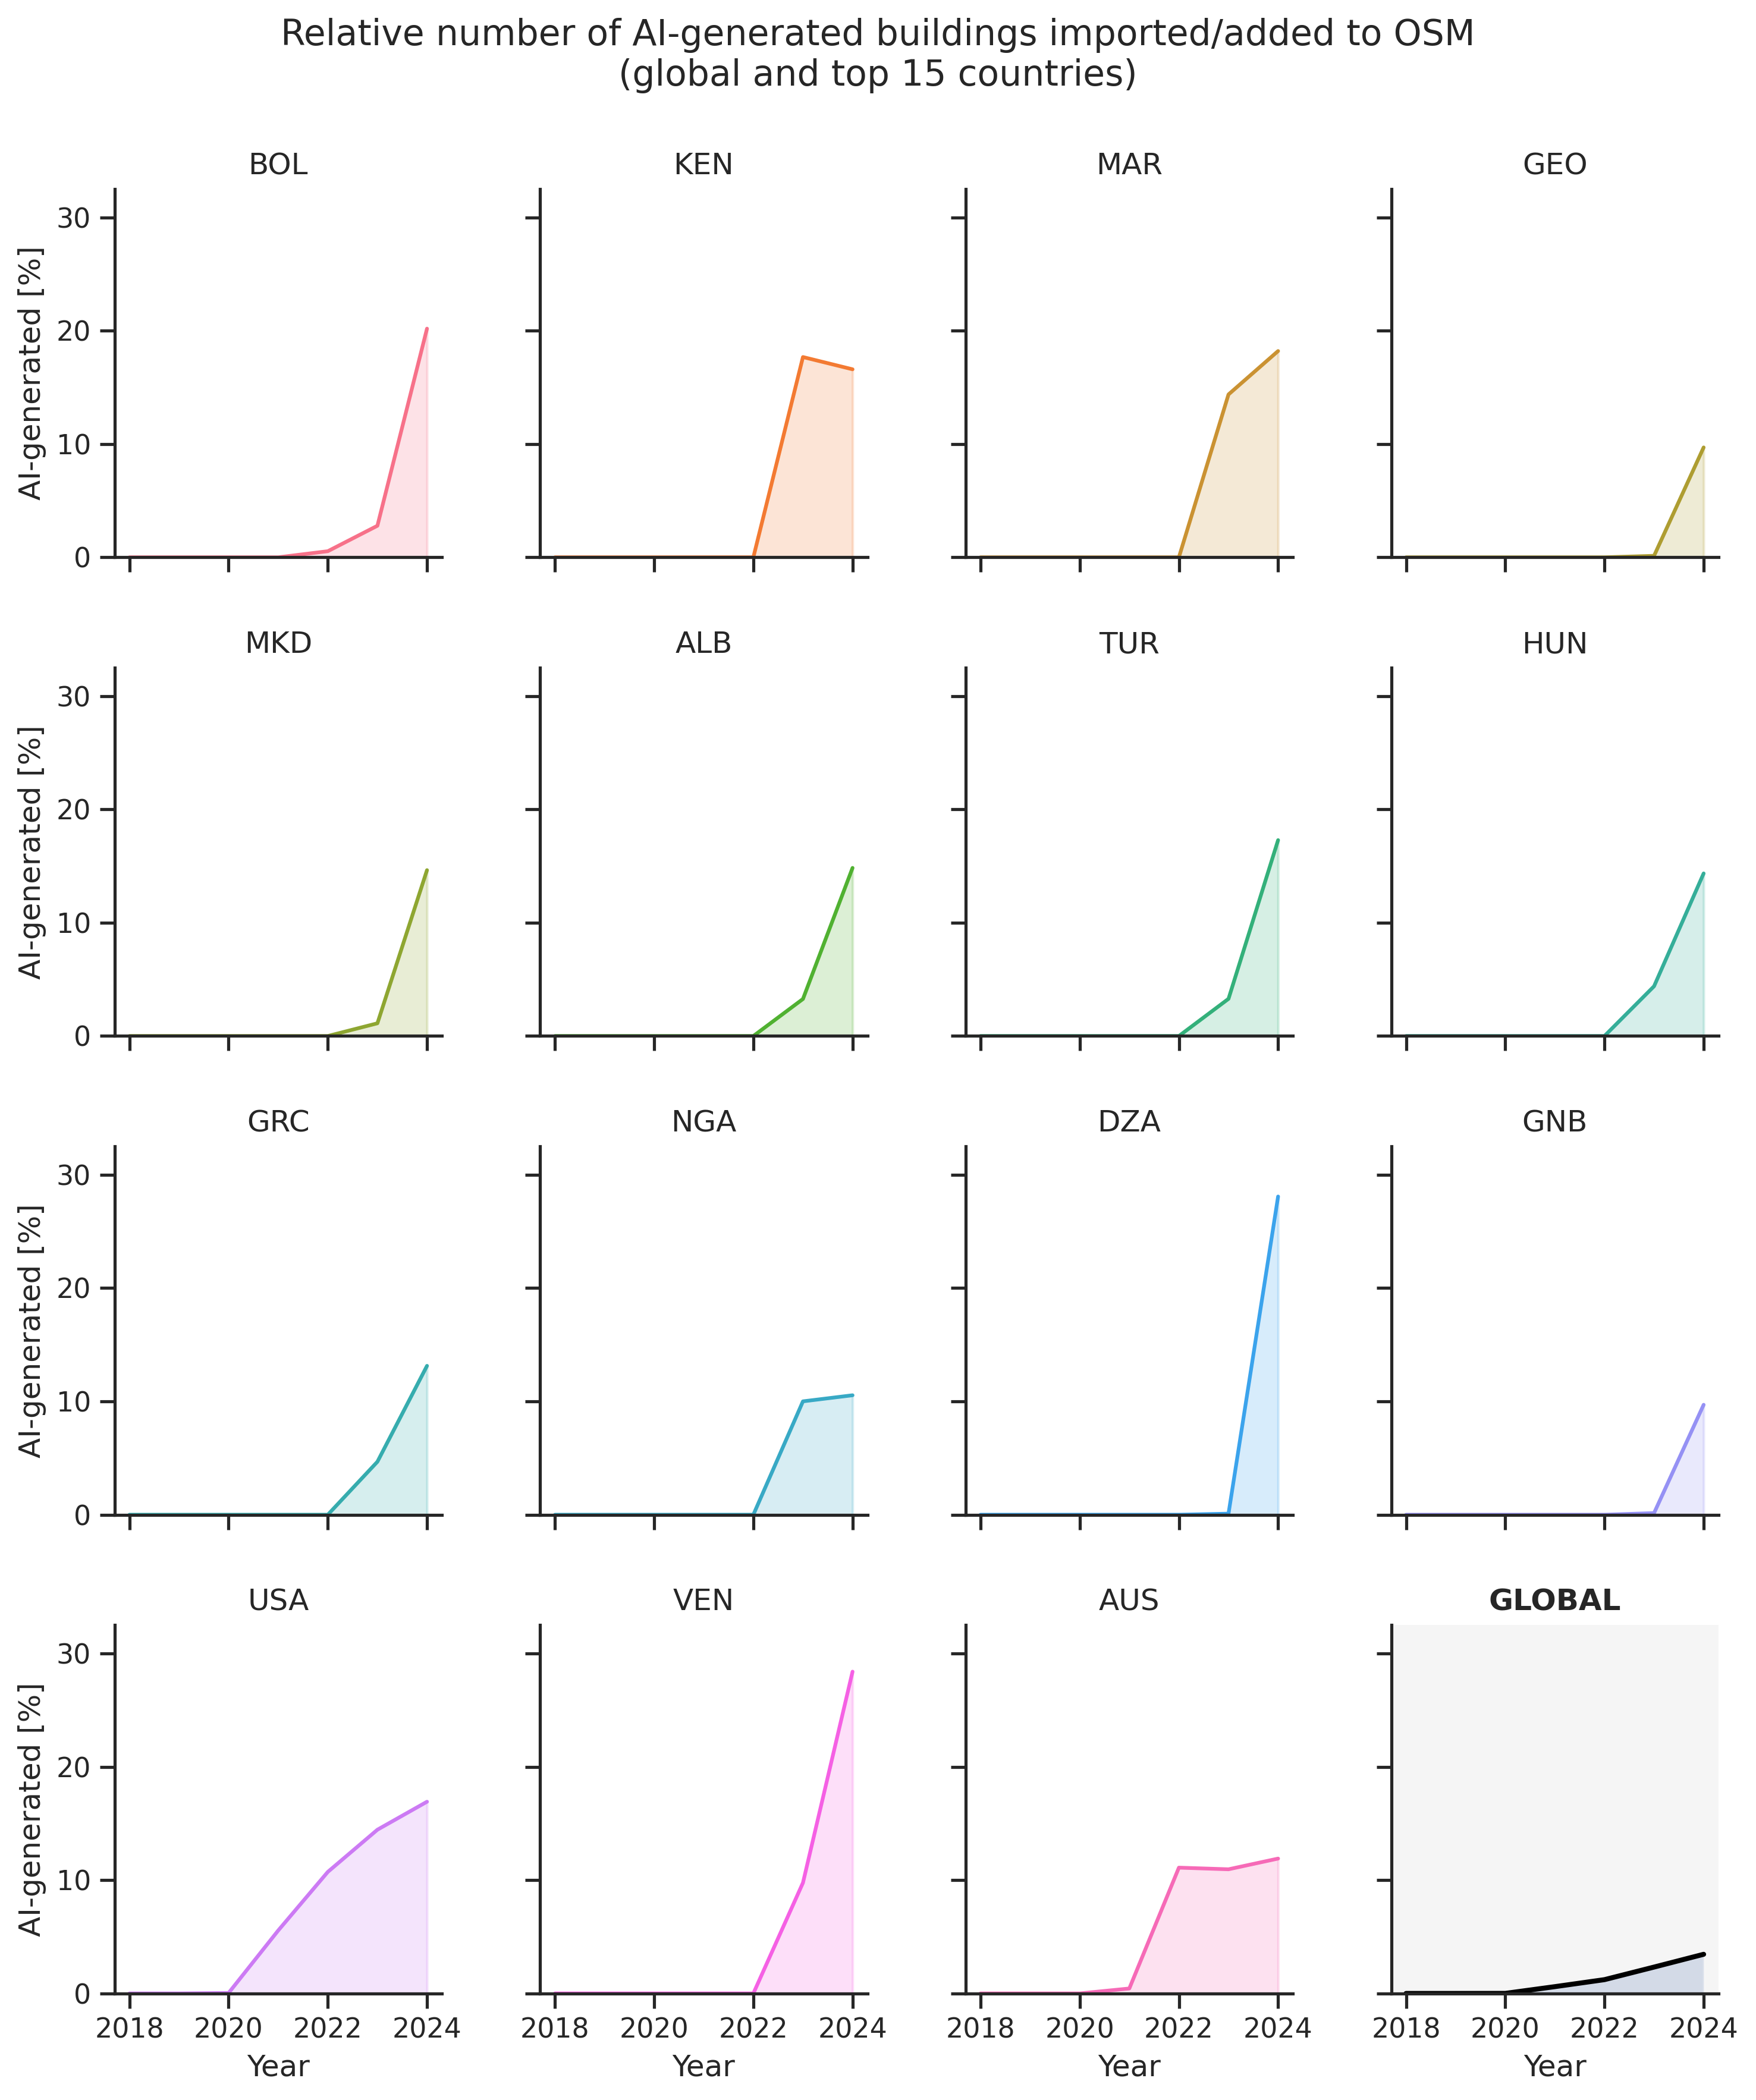

In [10]:
# filter top 15 countries percentage
df_ai_filter_percentage = df_ai[df_ai['adm0_iso'].isin(top_15_countries_percentage)]

# figure configuration
sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_context('notebook')
sns.set_style("ticks")

# create a FacetGrid for the first dataframe
g = sns.FacetGrid(
    df_ai_filter_percentage,
    col='adm0_iso',
    hue='adm0_iso',
    col_wrap=4,
    height=3, 
    aspect=1.
)

# adjust the size of the figure
fig = plt.gcf()
fig.set_size_inches(10, 12)

# plot the data on the FacetGrid
g = g.map(plt.plot, 'blds_year', 'percentage')
g = g.map(plt.fill_between, 'blds_year', 'percentage', alpha=0.2)

# set the x-axis labels to be rotated
#[plt.setp(ax.get_xticklabels(), rotation=45) for ax in g.axes.flat]

# set the titles for each subplot based on the 'name' column
g.set_titles("{col_name}")



# set the axes titles and limits
axes = g.axes.flatten()

for i, ax in enumerate(axes):
    ax.set_xlabel("Year")
    ax.set_ylabel("AI-generated [%]")
    ax.set_ylim((0, 32.5))

# create a new plot axis for the second dataframe
ax2 = plt.subplot(4, 4, 16)

# plot the data from the second dataframe on the new axis
sns.lineplot(
    data=df_ai_all,
    x='blds_year',
    y='percentage',
    color='black',
    linewidth=2
)

ax2.fill_between(
    df_ai_all['blds_year'],
    df_ai_all['percentage'],
    alpha=0.2
)

# set the title and axes labels for the new plot axis
ax2.set_title('GLOBAL', weight='bold')
ax2.set_xlabel('Year')
ax2.set_ylabel('')
ax2.set_yticks([0, 10, 20, 30], ['', '', '', ''])
ax2.set_ylim((0, 32.5))
ax2.set_facecolor('whitesmoke')

# remove the top and right spines of all subplots
sns.despine()

axes[11].set_xlabel('')
axes[11].tick_params(labelcolor='white', which='both')

# add a title for the whole plot
plt.subplots_adjust(top=0.90, hspace=0.3, wspace=0.3)
g.fig.suptitle('Relative number of AI-generated buildings imported/added to OSM\n(global and top 15 countries)')

# show the plot
plt.savefig("../plots/percentage-evolution-microsoft-ai-blds.png")
plt.show()